In [1]:
import numpy as np
import pandas as pd

### read the file

In [2]:
patent_abstract = pd.read_csv('US_patent_abstract_50000_2015_with_title_1_5y.csv')
patent_abstract.shape

(50000, 30)

In [3]:
patent_abstract['quality_rank'].value_counts()

0    29709
1    20291
Name: quality_rank, dtype: int64

In [4]:
29709/50000

0.59418

In [5]:
data_train = patent_abstract

In [6]:
import numpy as np
import pandas as pd
import pickle as cPickle
from collections import defaultdict
import re

from bs4 import BeautifulSoup

import sys
import os
import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model

from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers

Using TensorFlow backend.


In [7]:
MAX_SENT_LENGTH = 30
MAX_SENTS = 30
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.1

### tokenize the text

In [8]:
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [9]:
import nltk
from nltk import tokenize

claims = [] # abstracts is list of list of list to hold each sentences of each abstract (the most complete data)
labels = [] # label is just a list holding our label which is quality_index
texts = []  # texts to hold each complete abstract as list of list (note: abstract not breaking up to sentence level)
for idx in range(data_train.text.shape[0]): # for each row
    text = clean_str(str(data_train.iloc[idx]['claims_text'])) # text is each complete abstract
    texts.append(text) # texts to hold each complete abstract as list of string (note: abstract not breaking up to sentence level)
    sentences = tokenize.sent_tokenize(text) # sentences is list of string holding each complete sentence 
    claims.append(sentences) # abstracts is list of list of string to hold each sentences of each abstract (the most complete data)
    labels.append(data_train.iloc[idx]['quality_rank']) # label is just a list holding our label which is quality_index

In [10]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS) # intend to use next line .fit_on_texts to index each word within specific abstract at current iteration/loop, the more frequent word has lower index number, it is a dictionary format, it's like a unique vocabulary index
tokenizer.fit_on_texts(texts)
data = np.zeros((len(texts), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')

In [11]:
tokenizer.word_counts

OrderedDict([('what', 28582),
             ('is', 794620),
             ('claimed', 72505),
             ('1', 494412),
             ('a', 2480970),
             ('user', 89077),
             ('equipment', 9643),
             ('ue', 7659),
             ('device', 292601),
             ('the', 5263156),
             ('comprising', 303590),
             ('an', 484884),
             ('antenna', 14188),
             ('for', 325171),
             ('performing', 17401),
             ('wireless', 29940),
             ('communications', 10520),
             ('with', 297384),
             ('base', 45868),
             ('station', 18503),
             ('memory', 60959),
             ('which', 130793),
             ('stores', 4258),
             ('plurality', 196659),
             ('of', 2413327),
             ('sets', 8586),
             ('communication', 64756),
             ('scenario', 590),
             ('information', 125914),
             ('each', 172497),
             ('scenarios', 234),


In [12]:
tokenizer.document_count

50000

In [13]:
len(tokenizer.word_index) # 143937 unqiue vocabulary out of the entire abstract dataset

102990

In [14]:
for i, sentences in enumerate(claims):
    for j, sent in enumerate(sentences):
        if j < MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k = 0
            for _, word in enumerate(wordTokens):
            #for word in wordTokens:
                if word in tokenizer.word_index.keys():
                    if (k < MAX_SENT_LENGTH) and (tokenizer.word_index[word] < MAX_NB_WORDS):
                        data[i, j, k] = tokenizer.word_index[word]
                        k = k + 1

In [15]:
word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

Total 102990 unique tokens.


In [16]:
np.unique(np.asarray(labels))

array([0, 1])

In [17]:
labels = to_categorical(np.asarray(labels), num_classes=2) 
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (50000, 30, 30)
Shape of label tensor: (50000, 2)


In [18]:
#indices = np.arange(data.shape[0])
#np.random.shuffle(indices)
#data = data[indices]
#labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])
nb_test_samples = int(TEST_SPLIT * data.shape[0])

In [19]:
x_train = data[:-(nb_validation_samples+nb_test_samples)]
y_train = labels[:-(nb_validation_samples+nb_test_samples)]
x_val = data[-(nb_validation_samples+nb_test_samples):-nb_test_samples]
y_val = labels[-(nb_validation_samples+nb_test_samples):-nb_test_samples]
x_test = data[-nb_test_samples:]
y_test = labels[-nb_test_samples:]

print('Number of positive and negative reviews in traing, validation, and test set')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))
print(y_test.sum(axis=0))

Number of positive and negative reviews in traing, validation, and test set
[20815. 14185.]
[5898. 4102.]
[2996. 2004.]


In [20]:
x_train[2]

array([[ 1893,     8,    12,    13,  1489,  3296,   498,   584,    20,
            2,   290,   106,    20,     2,  1198,    37,    86,     2,
          498,    58,     5,    13,   791,    58,     2,  1022,   498,
           37,    20,     2],
       [   28,     1,   584,     3,     8,    12,     6,     1,   290,
          106,    33,    34,    13,  3587,    37,  1892,    95,     4,
            1,   498,    58,     3,     1,  1198,    37,     5,     1,
         1022,   498,    37],
       [   35,     1,   584,     3,     8,    28,     6,     1,  3587,
           37,    34,    15,    23,    16,   324,   783,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [   39,     1,   584,     3,     8,    35,     6,     1,    15,
           23,    16,   324,   783,    62,     2, 11799,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [   44,     1,   584,

In [21]:
x_val[10]

array([[   12,     2,    24,    19,  1977,    13,  1296,   607,     3,
          331,   803,  2608,  2673,     1,    24,    20,     1,   467,
            3,  1977,    13,  4662,  1296,   607,   121,    13,  4662,
         6810,   415,  5367],
       [   28,     1,    24,     3,     8,    12,     6,  6598,   228,
          386,    35,  5239,    39,     7,    33,  1726,     4,     1,
         1296,  2608,  2673,   607,     0,     0,     0,     0,     0,
            0,     0,     0],
       [   35,     1,    24,     3,     8,    12,     6,     1,  4662,
         6810,   415,     7,   395,    16,    90,    18,  7521,   228,
            5, 11867,  1896,  4626,  9275,  3714,   228,     0,     0,
            0,     0,     0],
       [   39,     1,    24,     3,     8,    12,     6,     1,  2608,
         2673,    56,   237,     7,    15,    23,    16,    90,    18,
            1,    67,     3, 15369, 14809,  4607,    66, 19669,  2673,
            5,  2608,   502],
       [   44,     1,    24,

In [22]:
x_train.shape

(35000, 30, 30)

In [23]:
np.unique(y_val, return_counts=True)

(array([0., 1.], dtype=float32), array([10000, 10000]))

### use GloVe for embedding

In [24]:
# Standard python helper libraries.
import os, sys, re, json, time
import itertools, collections
from importlib import reload
from IPython.display import display

# NumPy and SciPy for matrix ops

import scipy.sparse


# Helper libraries
from w266_common import utils, vocabulary, tf_embed_viz
import glove_helper; reload(glove_helper)

<module 'glove_helper' from '/home/nobu_yamaguchi/final_project/glove_helper.py'>

In [25]:
GLOVE_DIR = "data/glove"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [26]:
print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [27]:

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
print(embedding_matrix.shape)
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

(102991, 100)


In [28]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SENT_LENGTH,
                            trainable=False)

sentence_input = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
sentEncoder = Model(sentence_input, l_lstm)

claims_input = Input(shape=(MAX_SENTS,MAX_SENT_LENGTH), dtype='int32')
claims_encoder = TimeDistributed(sentEncoder)(claims_input)
l_lstm_sent = Bidirectional(LSTM(100))(claims_encoder)
l_lstm_dense = Dense(100, activation='relu')(l_lstm_sent)
l_lstm_dense = Dense(100, activation='relu')(l_lstm_dense)
l_lstm_dense = Dense(100, activation='relu')(l_lstm_dense)
l_lstm_sent_drop = Dropout(rate=0.4)(l_lstm_dense)
preds = Dense(2, activation='sigmoid')(l_lstm_sent_drop) # [Steven] why 5 will throw error and require 6 ? it is weird since we only have 5 number scale
model = Model(claims_input, preds)

In [29]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [30]:
print("model fitting - Hierachical LSTM max_sent = 30, dropout = 0.4")
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=10, batch_size=50)

model fitting - Hierachical LSTM max_sent = 30, dropout = 0.4
Train on 35000 samples, validate on 10000 samples
Epoch 1/10
35000/35000 [==============================] - 401s 11ms/step - loss: 0.6114 - acc: 0.6687 - val_loss: 0.6081 - val_acc: 0.6771
Epoch 2/10
35000/35000 [==============================] - 398s 11ms/step - loss: 0.5968 - acc: 0.6827 - val_loss: 0.5873 - val_acc: 0.6884
Epoch 3/10
35000/35000 [==============================] - 398s 11ms/step - loss: 0.5891 - acc: 0.6882 - val_loss: 0.5902 - val_acc: 0.6894
Epoch 4/10
35000/35000 [==============================] - 398s 11ms/step - loss: 0.5814 - acc: 0.6976 - val_loss: 0.5838 - val_acc: 0.6906
Epoch 5/10
35000/35000 [==============================] - 398s 11ms/step - loss: 0.5723 - acc: 0.7023 - val_loss: 0.5824 - val_acc: 0.6929
Epoch 6/10
35000/35000 [==============================] - 398s 11ms/step - loss: 0.5593 - acc: 0.7110 - val_loss: 0.5862 - val_acc: 0.6923
Epoch 7/10
35000/35000 [==============================

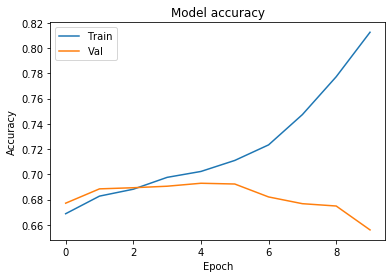

In [31]:
# Plot training & validation accuracy values
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [51]:
pred_test = model.predict(x_val)
np.savetxt('LSTM_5y_50k.csv', pred_test)

In [52]:
model.save("model/LSTM_5y_50k")

In [53]:
test_result = model.evaluate(x_test, y_test)
print("test loss, test acc:", test_result)

5000/5000 [==============================] - 28s 6ms/step
test loss, test acc: [0.583721869468689, 0.6962000131607056]
